# 1. Import the required libraries

In [1]:
# Standard code libraries
import os
import matplotlib.pyplot as plt
import numpy as np

# Custom code libraries from ReSurfEMG
from resurfemg.data_connector.config import Config
from resurfemg.data_connector import file_discovery
from resurfemg.postprocessing import features as feat
from resurfemg.postprocessing import quality_assessment as qa
from resurfemg.pipelines import ipy_widgets
from resurfemg.data_connector.tmsisdk_lite import Poly5Reader
from resurfemg.data_connector.data_classes import (
VentilatorDataGroup, EmgDataGroup)

%matplotlib widget

## 2. Load the ventilator and sEMG data

In [2]:
# Identify all recordings available for the selected patient/measurement_date

# First find the patients
config = Config()

# Then find the files for the selected patients:
base_path = config.get_directory('test_data')
folder_levels = None

emg_files = file_discovery.find_files(
    base_path=base_path,
    file_name_regex='emg_data_synth_pocc',
    extension_regex='poly5',
    folder_levels=None)

folder_levels = ['date', 'measurement']
vent_files = file_discovery.find_files(
    base_path=base_path,
    file_name_regex='vent_data_synth_pocc',
    extension_regex='poly5',
    folder_levels=None)

In [3]:
# If you want to select another file:
# btn_list_emg = ipy_widgets.file_select(
#     emg_files,
#     folder_levels=['files'],
#     default_value_select=None,
#     default_idx_select=[0])
# btn_list_vent = ipy_widgets.file_select(
#     vent_files,
#     folder_levels=['files'],
#     default_value_select=None,
#     default_idx_select=[0])

In [4]:
# Load the EMG and ventilator data recordings from the selected folders.
emg_file_chosen = os.path.join(base_path, emg_files['files'].values[0])
vent_file_chosen = os.path.join(base_path, vent_files['files'].values[0])
# Alternatively:
# emg_file_chosen = os.path.join(base_path, *[btn.value for btn in btn_list_emg])
# vent_file_chosen = os.path.join(base_path, *[btn.value for btn in btn_list_vent])

data_emg = Poly5Reader(emg_file_chosen)
data_vent = Poly5Reader(vent_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
fs_emg = data_emg.sample_rate
data_vent_samples = data_vent.samples[:data_vent.num_samples]
fs_vent = data_vent.sample_rate

# Define the time series of the EMG and ventilator recordings
y_emg = data_emg_samples
y_vent = data_vent_samples

# Define the time axes
t_emg = [i/fs_emg for i in range(len(y_emg[0, :]))]
t_vent = [i/fs_vent for i in range(len(y_vent[0, :]))]

Reading file  C:\Users\WarnaarRSP\Repos\ReSurfEMG\ReSurfEMG\test_data\emg_data_synth_pocc.poly5
	 Number of samples:  860160 
	 Number of channels:  2 
	 Sample rate: 2048 Hz
Done reading data.
Reading file  C:\Users\WarnaarRSP\Repos\ReSurfEMG\ReSurfEMG\test_data\vent_data_synth_pocc.poly5
	 Number of samples:  42000 
	 Number of channels:  3 
	 Sample rate: 100 Hz
Done reading data.


In [5]:
# Store the EMG data in a group of TimeSeries objects
emg_timeseries = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=['ECG', 'EMGdi'],
    units=2*['uV'])

Auto-detected ECG channel from labels.


In [6]:
# Store the ventilator data in a group of TimeSeries objects
vent_timeseries = VentilatorDataGroup(
    y_vent,
    fs=fs_vent,
    labels=['Paw', 'F', 'Vvent'],
    units=['cmH2O', 'L/s', 'L'])

Auto-detected Pvent channel from labels.
Auto-detected Flow channel from labels.
Auto-detected Volume channel from labels.


# 3. Pre-process the data

In [7]:
# Filter
emg_timeseries.run('filter_emg')

In [8]:
# # Through gating
# emg_timeseries.gating(overwrite=True)
emg_timeseries.run('gating', overwrite=True)

# # Through wavelet denoising
# emg_timeseries.run('wavelet_denoising', overwrite=True)
# # emg_timeseries.run('wavelet_denoising', n=8, fixed_threshold=8.0, overwrite=True)

Set ECG channel used for ECG removal.


In [9]:
# Calculate the envelope of the signal
# emg_timeseries.run('envelope')
emg_timeseries.run('envelope', ci_alpha=0.05)
# emg_timeseries.run('envelope', env_type='arv')
# emg_timeseries.run('envelope', env_type='arv', ci_alpha=0.05)

In [10]:
# Calculate the baseline for the EMG envelopes and p_vent
emg_timeseries.run('baseline')
vent_timeseries.run(
    'baseline',
    channel_idxs=[0],
    signal_type='raw')

(370.0, 410.0)

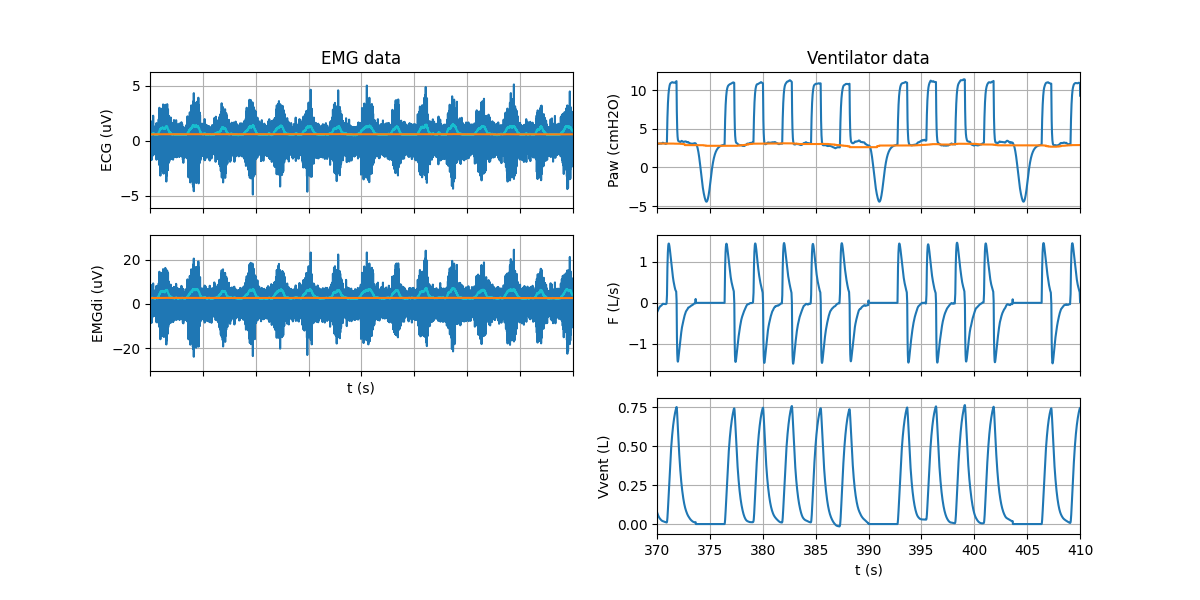

In [11]:
# Plot the raw data with the envelope
# EMG data
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(12, 6), sharex=True)
axes_emg = axis[:2, 0]
colors = ['tab:cyan', 'tab:orange']
emg_timeseries.run(
    'plot_full', axes=axes_emg, signal_type='clean', baseline_bool=False)
emg_timeseries.run(
    'plot_full', axes=axes_emg, signal_type='env', colors=colors)

axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

# Ventilator data data
axes_vent = axis[:, 1]
vent_timeseries.run('plot_full', axes=axes_vent)
axes_vent[0].set_title('Ventilator data')
axes_vent[-1].set_xlabel('t (s)')

axis[-1, 0].axis('off')

axes_vent[-1].set_xlim([370, 410])

# 3. Identify Pocc peaks of interest in p_vent

In [12]:
# Find occlusion pressures
vent_timeseries.peep
vent_timeseries.find_occluded_breaths(
    vent_timeseries.p_vent_idx, start_idx=360*vent_timeseries.param['fs'])

In [13]:
# Detect on- and offsets of occlusion pressure peaks
p_vent = vent_timeseries[vent_timeseries.p_vent_idx]
p_vent.peaks['Pocc'].detect_on_offset(baseline=p_vent.y_baseline)

print('The timings of the Pocc peaks is at:')
print(p_vent.peaks['Pocc']['peak_idx']/p_vent.param['fs'])

The timings of the Pocc peaks is at:
[374.65 391.01 404.65]


In [14]:
# Find supported breath pressures
v_vent = vent_timeseries[vent_timeseries.v_vent_idx]
vent_timeseries.find_tidal_volume_peaks()


# 4. Identify all sEMG breaths, and find those closest to the Pocc peaks

In [15]:
# Find sEAdi peaks in one channel (sEAdi)
emg_di = emg_timeseries['EMGdi']
emg_di.detect_emg_breaths(peak_set_name='breaths')

# Similar to above for Pocc and ventilator breaths:
emg_di.peaks['breaths'].detect_on_offset(
    baseline=emg_di.y_baseline
)

In [16]:
# Find the EMG peaks with the peak timing closest to the Pocc timings, and
# link ventilator Pocc peaks to EMG breaths
t_pocc_peaks_vent = p_vent.peaks['Pocc']['peak_idx'] / p_vent.param['fs']

emg_di.link_peak_set(
    peak_set_name='breaths',
    t_reference_peaks=t_pocc_peaks_vent,
    linked_peak_set_name='Pocc',
)
print('The timings of the Pocc peaks is in sEMGdi are at:')
print(emg_di.peaks['Pocc']['start_idx']/emg_di.param['fs'])


The timings of the Pocc peaks is in sEMGdi are at:
[373.41259766 389.71386719 403.41259766]


(370.0, 410.0)

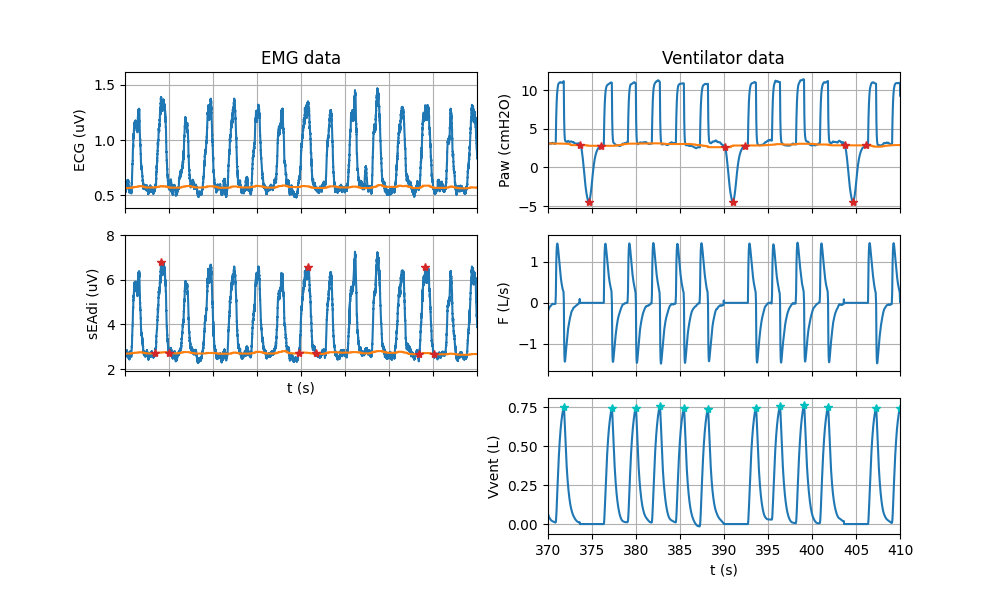

In [17]:
# Plot the identified Pocc peaks in p_vent and sEAdi
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)
axes_emg = axis[:-1, 0]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_timeseries.run('plot_full', axes=axes_emg, signal_type='env')
emg_di.plot_markers(peak_set_name='Pocc', axes=axes_emg[1])


axes_emg[1].set_ylabel('sEAdi (uV)')
axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

axes_vent = axis[:, 1]
vent_timeseries.run('plot_full', axes=axes_vent)
p_vent.plot_markers(peak_set_name='Pocc', axes=axes_vent[0])
v_vent.plot_markers(peak_set_name='ventilator_breaths',
                    axes=axes_vent[2], colors='c')

axes_vent[0].set_title('Ventilator data')
axes_vent[-1].set_xlabel('t (s)')
axis[-1, 0].axis('off')

# Let's zoom in on the Pocc peaks:
axes_vent[-1].set_xlim([370, 410])

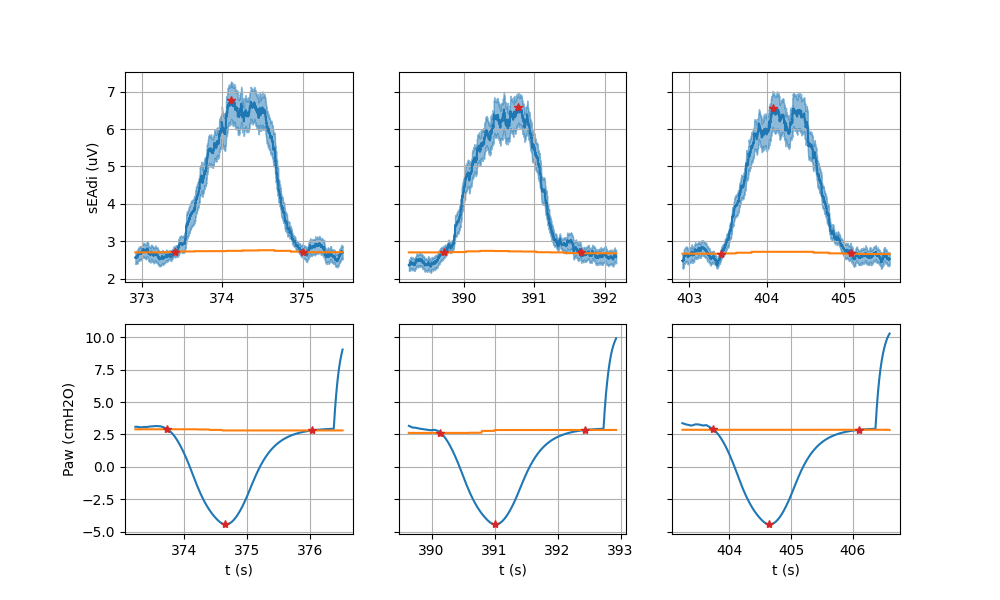

In [18]:
# Plot the individual peaks
n_peaks = len(emg_di.peaks['Pocc']['start_idx'])
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(10, 6), sharey='row')

axes_emg = axis[0, :]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='Pocc', plot_ci=True)
emg_di.plot_markers(axes=axes_emg, peak_set_name='Pocc')
axes_emg[0].set_ylabel('sEAdi (uV)')

axes_vent = axis[1, :]
p_vent.plot_peaks(axes=axes_vent, peak_set_name='Pocc')
p_vent.plot_markers(axes=axes_vent, peak_set_name='Pocc')

for axis in axes_vent:
    axis.set_xlabel('t (s)')

# 5. Calculate features

In [19]:
# Respiratory rates
tv_idxs = v_vent.peaks['ventilator_breaths']['peak_idx']
rr_vent, _ = feat.respiratory_rate(
    tv_idxs, fs_vent
)

rr_vent, _ = feat.respiratory_rate(
    v_vent.peaks['ventilator_breaths']['peak_idx'],
    v_vent.param['fs'])
v_vent.param['rr'] = rr_vent
p_vent.param['rr'] = rr_vent
print('The detected respiratory rate in the ventilator data is: '
      + f'{round(rr_vent, 1)} /min')

emg_di_idxs = emg_di.peaks['breaths']['peak_idx']
rr_emg, _ = feat.respiratory_rate(
    emg_di_idxs, fs_emg
)
emg_di.param['rr'] = rr_emg
print('The detected respiratory rate in the sEAdi data is: '
      + f'{round(rr_emg, 1)} /min')

The detected respiratory rate in the ventilator data is: 22.0 /min
The detected respiratory rate in the sEAdi data is: 22.0 /min


In [20]:
# EMG amplitudes
emg_di_pocc_idxs = emg_di.peaks['Pocc']['peak_idx']
sEAdi_amplitudes = feat.amplitude(
    signal=emg_di.y_env,
    peak_idxs=emg_di_pocc_idxs,
    baseline=emg_di.y_baseline,
)
print('The sEAdi amplitudes are:')
print(sEAdi_amplitudes)

The sEAdi amplitudes are:
[4.04940309 3.86127861 3.84515852]


In [21]:
# Calculate PTPocc
p_vent.calculate_time_products(
    peak_set_name='Pocc', 
    aub_reference_signal=p_vent.y_baseline,
    parameter_name='PTPocc')
print(p_vent.peaks['Pocc'])

   peak_idx  start_idx  end_idx  valid       AUB  aub_y_ref    PTPocc
0     37465      37372    37602   True  0.629043   3.112269  7.967947
1     39101      39014    39244   True  0.612831   3.043785  7.816193
2     40465      40374    40611   True  0.503030   3.074270  7.895531


In [22]:
# Calculate ETPdi
emg_di.calculate_time_products(
    peak_set_name='Pocc', parameter_name='ETPdi')

print(emg_di.peaks['Pocc'])

   peak_idx  start_idx  end_idx  valid       AUB  aub_y_ref     ETPdi
0    766176     764749   768001   True  0.726961   2.279110  4.313010
1    800300     798134   802124   True  0.764316   2.321897  4.576422
2    827555     826189   829630   True  0.590109   2.345028  4.256199


# 6. Test Pocc and sEMG quality

In [23]:
# Test general signal characteristics
fraction_emg_breaths, _ = qa.evaluate_respiratory_rates(
    emg_breath_idxs=emg_di_idxs,
    t_emg=max(emg_di.t_data),
    rr_vent=rr_vent
)
print('The fraction detected EMG breaths is: {:0.2f} %'.format(
    100*fraction_emg_breaths))

The fraction detected EMG breaths is: 100.10 %


In [24]:
# Test Pocc quality
parameter_names = {
    'time_product': 'PTPocc'
}
p_vent.test_pocc_quality(
    peak_set_name='Pocc',
    parameter_names=parameter_names, 
    verbose=True)

Test values:
    peak_idx  dP_up_10  dP_up_90  dP_up_90_norm
0     37465  0.009708  0.110633       0.039193
1     39101  0.008363  0.109885       0.039304
2     40465  0.007633  0.109652       0.039023
Test outcomes:
    peak_idx  baseline_detection  consecutive_poccs  pocc_upslope
0     37465                True               True          True
1     39101                True               True          True
2     40465                True               True          True


In [25]:
# The peak-validity is updated in the peak_df:
print(p_vent.peaks['Pocc'])

   peak_idx  start_idx  end_idx  valid       AUB  aub_y_ref    PTPocc
0     37465      37372    37602   True  0.629043   3.112269  7.967947
1     39101      39014    39244   True  0.612831   3.043785  7.816193
2     40465      40374    40611   True  0.503030   3.074270  7.895531


In [26]:
# Test EMG quality
parameter_names = {
    'time_product': 'ETPdi'
}
emg_di.test_emg_quality(
    peak_set_name='Pocc', parameter_names=parameter_names, verbose=False)

In [27]:
# Test the ventilatory Pocc peaks against the EMG peaks
p_vent.param['rr_occ'] = 60*len(p_vent.peaks['Pocc'])/(p_vent.t_data[-1])
cutoff = {
    'fraction_emg_breaths': 0.1,
    'delta_min': 0.5*rr_vent/60,
    'delta_max': 0.6
}
parameter_names = {
    'rr': 'rr_occ'
}

emg_di.test_linked_peak_sets(
    peak_set_name='Pocc',
    linked_timeseries=p_vent,
    linked_peak_set_name='Pocc',
    verbose=True,
    cutoff=cutoff,
    parameter_names=parameter_names,
)

Test values:
    peak_idx       snr        aub  aub_y_refs       bell  detected_fraction  \
0    766176  2.486289  16.855076    2.279110   9.672712           0.999977   
1    800300  2.432448  16.701173    2.321897  10.553799           0.999977   
2    827555  2.438140  13.864700    2.345028  10.320326           0.999977   

   event_delta_time  
0          0.540625  
1          0.238516  
2          0.570410  
Test outcomes:
    peak_idx  baseline_detection  interpeak_distance   snr   aub  bell  \
0    766176                True                True  True  True  True   
1    800300                True                True  True  True  True   
2    827555                True                True  True  True  True   

   relative_aub  relative_etp  detected_fraction  event_timing  
0          True          True               True          True  
1          True          True               True          True  
2          True          True               True          True  


In [28]:
# The peak-validity is updated in the peak_df:
print(emg_di.peaks['Pocc'].peak_df)

   peak_idx  start_idx  end_idx  valid       AUB  aub_y_ref     ETPdi  \
0    766176     764749   768001   True  0.726961   2.279110  4.313010   
1    800300     798134   802124   True  0.764316   2.321897  4.576422   
2    827555     826189   829630   True  0.590109   2.345028  4.256199   

   bell_y_min    bell_a      bell_b    bell_c  
0    2.279110  4.579861  374.231900  0.561079  
1    2.321897  4.289192  390.593197  0.624578  
2    2.345028  4.316490  404.200751  0.588684  


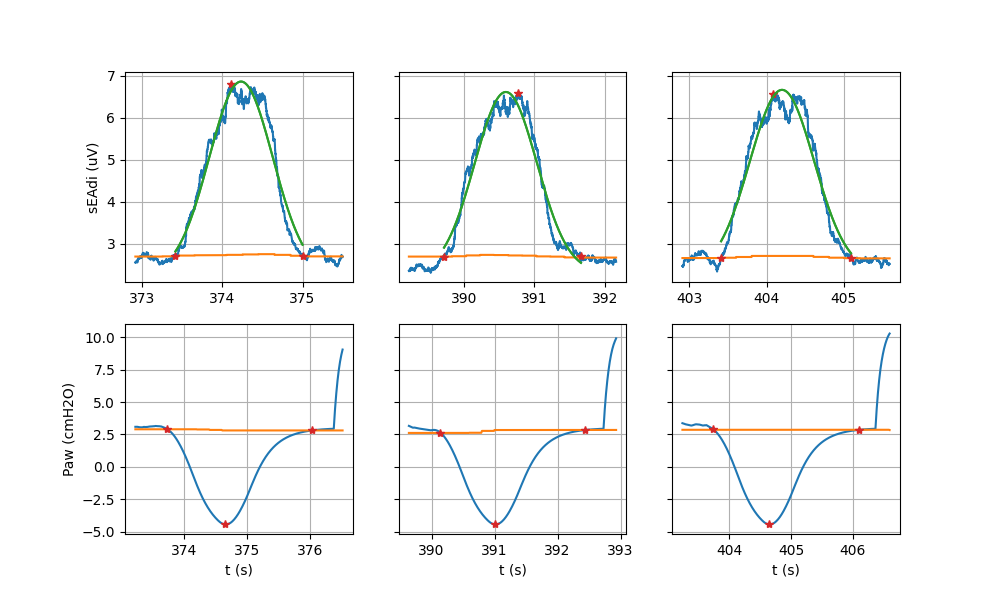

In [29]:
# Plot the individual peaks bell-fit
n_peaks = len(emg_di.peaks['Pocc'].peak_df['start_idx'])
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(10, 6), sharey='row')

axes_emg = axis[0, :]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='Pocc')
emg_di.plot_markers(axes=axes_emg, peak_set_name='Pocc')
emg_di.plot_curve_fits(axes=axes_emg, peak_set_name='Pocc')
axes_emg[0].set_ylabel('sEAdi (uV)')

axes_vent = axis[1, :]
p_vent.plot_peaks(axes=axes_vent, peak_set_name='Pocc')
p_vent.plot_markers(axes=axes_vent, peak_set_name='Pocc')

for axis in axes_vent:
    axis.set_xlabel('t (s)')

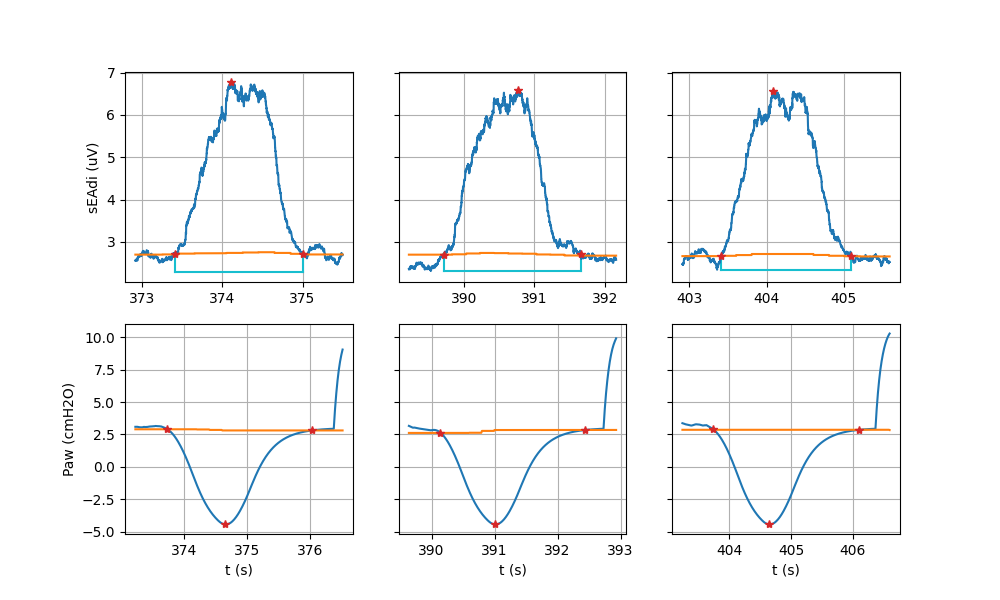

In [30]:
# Plot the individual peaks area under the baseline
n_peaks = len(emg_di.peaks['Pocc']['start_idx'])
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(10, 6), sharey='row')

axes_emg = axis[0, :]
emg_di.plot_aub(axes=axes_emg, signal_type='env', peak_set_name='Pocc')
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='Pocc')
emg_di.plot_markers(axes=axes_emg, peak_set_name='Pocc')
axes_emg[0].set_ylabel('sEAdi (uV)')

axes_vent = axis[1, :]
p_vent.plot_peaks(axes=axes_vent, peak_set_name='Pocc')
p_vent.plot_markers(axes=axes_vent, peak_set_name='Pocc')

for axis in axes_vent:
    axis.set_xlabel('t (s)')